In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import lombscargle as lbsc
from astropy.timeseries import LombScargle

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
with open('time.dat', 'r') as file:
    lineas = file.readlines()
time = np.zeros(len(lineas))
for i in range(len(lineas)):
    time[i] = float(lineas[i].strip())

In [5]:
#Abre el archivo master.raw (el primero de cuatro) y luego los divide en listas de estrellas
with open('master.raw', 'r') as file:
    # Lee todas las líneas del archivo
    lines = file.readlines()
match1 = []
valores = []
for i, line in tqdm(enumerate(lines)):
    # Usa split para dividir la línea en palabras
    valores.extend([float(word) for word in line.split()])
    # Verifica si ha leído 36 líneas
    if (i + 1) % 36 == 0:
        del valores[-2:]
        match1.append(valores)
        valores = []

578016it [00:03, 167151.81it/s]


In [6]:
with open('master2.raw', 'r') as file:
    # Lee todas las líneas del archivo
    lines = file.readlines()
match2 = []
valores = []
for i, line in tqdm(enumerate(lines)):
    # Usa split para dividir la línea en palabras
    valores.extend([float(word) for word in line.split()])

    # Verifica si hemos leído 36 líneas
    if (i + 1) % 36 == 0:
        del valores[-2:]
        del valores[3:5]
        # Imprime la lista de palabras para esta iteración
        # Reinicia la lista de palabras para la próxima iteración
        match2.append(valores)
        valores = []

479304it [00:02, 166803.12it/s]


In [7]:
with open('master3.raw', 'r') as file:
    # Lee todas las líneas del archivo
    lines = file.readlines()
match3 = []
valores = []
for i, line in tqdm(enumerate(lines)):
    # Usa split para dividir la línea en palabras
    valores.extend([float(word) for word in line.split()])

    # Verifica si hemos leído 36 líneas
    if (i + 1) % 36 == 0:
        del valores[-2:]
        del valores[3:5]
        # Imprime la lista de palabras para esta iteración
        # Reinicia la lista de palabras para la próxima iteración
        match3.append(valores)
        valores = []

433620it [00:03, 142371.77it/s]


In [8]:
with open('master4.raw', 'r') as file:
    # Lee todas las líneas del archivo
    lines = file.readlines()
match4 = []
valores = []
for i, line in tqdm(enumerate(lines)):
    # Usa split para dividir la línea en palabras
    valores.extend([float(word) for word in line.split()])

    # Verifica si hemos leído 36 líneas
    if (i + 1) % 37 == 0:
        del valores[-2:]
        del valores[3:5]
        # Imprime la lista de palabras para esta iteración
        # Reinicia la lista de palabras para la próxima iteración
        match4.append(valores)
        valores = []

349428it [00:02, 156785.88it/s]


In [9]:
#Función para unir los 4 archivos
def unir(mch1, mch2):
    mch3 = []
    for i in tqdm(range(len(mch1))):
        if mch1[i][0] < 200000:
            for j in range(len(mch2)):
                if mch1[i][0] == mch2[j][0]:
                    mch3.append(mch1[i] + mch2[j][3:])
    return mch3
mch1 = unir(match1, match2)
mch2 = unir(mch1, match3)
master = unir(mch2, match4)

100%|██████████| 10565/10565 [00:33<00:00, 312.78it/s]


In [10]:
#guarda la lista como un objeto .pickle
with open("master.pickle", "wb") as f:
    pickle.dump(master, f)

In [30]:
with open("master.pickle", "rb") as f:
    master = pickle.load(f)

In [31]:
#obtiene los ids de acuerdo a la imagen máster
ids = []
xcoo = []
ycoo = []
for i in tqdm(range(len(master))):
    ids.append(master[i][0])
    xcoo.append(master[i][1])
    ycoo.append(master[i][2])

100%|██████████| 8618/8618 [00:00<00:00, 326957.97it/s]


In [32]:
#Divide entre magnitudes y errores para cada lista.
def getmag(master):
    mag = []
    merr = []
    for i in tqdm(range(len(master))):
        mast = master[i][3:]
        mag2 = []
        merr2 = []
        
        for j in range(len(mast)):
            if (j+2)%2==0:
                mag2.append(mast[j])
            else:
                merr2.append(mast[j])
        mag.append(np.array(mag2))
        merr.append(np.array(merr2))
    return mag, merr
mag, merr = getmag(master)

100%|██████████| 8618/8618 [00:04<00:00, 1972.05it/s]


In [33]:
for i in tqdm(range(len(mag))):
    mag[i][mag[i]==99.9999] = np.nan
    merr[i][merr[i]==9.9999] = np.nan

100%|██████████| 8618/8618 [00:00<00:00, 55115.34it/s]


In [34]:
with open("magMaster.pickle", "wb") as f:
    pickle.dump(mag, f)
with open("merrMaster.pickle", "wb") as f:
    pickle.dump(master, f)

In [9]:
with open("magMaster.pickle", "rb") as f:
    mag = pickle.load(f)
with open("merrMaster.pickle", "rb") as f:
    merr = pickle.load(f)

87.764

In [13]:
np.nanstd(mag[1000])

0.20753657862999558

In [35]:
magt = []
merrt = []
idt = []
xcoot = []
ycoot = []
for i in tqdm(range(len(mag))):
    len_sin_nan = np.count_nonzero(~np.isnan(mag))
    if len_sin_nan >= 63:
        magt.append(mag[i])
        merrt.append(merr[i])
        idt.append(ids[i])
        xcoot.append(xcoo[i])
        ycoot.append(ycoo[i])

100%|██████████| 8618/8618 [06:19<00:00, 22.70it/s]


In [36]:
with open("magMT.pickle", "wb") as f:
    pickle.dump(magt, f)
with open("merrMT.pickle", "wb") as f:
    pickle.dump(merrt, f)
with open("idMT.pickle", "wb") as f:
    pickle.dump(idt, f)
with open("xcooMT.pickle", "wb") as f:
    pickle.dump(xcoot, f)
with open("ycooMT.pickle", "wb") as f:
    pickle.dump(ycoot, f)

In [37]:
with open("magMT.pickle", "rb") as f:
    mag = pickle.load(f)
with open("merrMT.pickle", "rb") as f:
    merr = pickle.load(f)
with open("idMT.pickle", "rb") as f:
    ids = pickle.load(f)
with open("xcooMT.pickle", "rb") as f:
    xcoo = pickle.load(f)
with open("ycooMT.pickle", "rb") as f:
    ycoo = pickle.load(f)

In [38]:
print(ids[5702], mag[5702][100], merr[5702][100], xcoo[5702], ycoo[5702])

9450.0 19.297 0.065 2614.866 3048.896


In [39]:
desv = []
prom = []
for i in tqdm(range(len(mag))):
    prom.append(np.nanmean(mag[i]))
    desv.append(np.nanstd(mag[i]))

100%|██████████| 8618/8618 [00:01<00:00, 6447.16it/s]


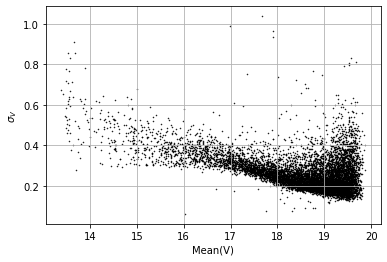

In [46]:
plt.scatter(prom, desv, c='k', s=0.25)
plt.xlabel('Mean(V)')
plt.ylabel(r'$\sigma_{V}$')
plt.grid()
plt.savefig('daoMeanDesv_sinFiltrar.pdf')


In [24]:
mag_1 = mag[0:2873]
mag_2 = mag[2873:5744]
mag_3 = mag[5744:]

ids_1 = ids[0:2873]
ids_2 = ids[2873:5744]
ids_3 = ids[5744:]

def func_plotBox(x,i):
    
    data = [value for value in x if not np.isnan(value)]
    
    plt.boxplot(data)
    plt.ylabel('V')
    plt.title(f'ID_{int(i)}')
    pdf.savefig()
    plt.close()
    
with PdfPages('MagBoxDao_1.pdf') as pdf: 
    for i in tqdm(range(len(ids_1))):
        func_plotBox(mag_1[i], ids_1[i])

In [ ]:
with PdfPages('MagBoxDao_3.pdf') as pdf: 
    for i, magt in tqdm(enumerate(mag_3)):
        datos = [value for value in magt if not np.isnan(value)]
        if i%4 == 0:
            fig, axs = plt.subplots(2, 2, figsize=(10, 8))
            
        fila = i%2 #se decide si el plot estará arriba o abajo
        columna = (i // 2)%2
        
        axs[fila, columna].boxplot(datos)
        axs[fila, columna].invert_yaxis()
        axs[fila, columna].set_ylabel('V')
        axs[fila, columna].set_title(f'ID_{int(ids_3[i])}, i={i}')
        
        if (i+1) % 4==0 or (i+1)==len(mag_3):
            pdf.savefig(fig)
            plt.close(fig)

2592it [06:29,  7.25it/s]

In [42]:
def elimatp(mag, merr, time):
    
    data = [value for value in mag if not np.isnan(value)]
    boxplot = plt.boxplot([data], flierprops = dict(markerfacecolor='red', marker='o'))
    atpos = [item.get_ydata() for item in boxplot['fliers']]

    magt = []
    merrt = []
    timet = []
    for i in range(len(mag)):
        if mag[i] not in atpos[0]:
            magt.append(mag[i])
            merrt.append(merr[i])
            timet.append(time[i])
    magt = np.array(magt)
    merrt = np.array(merrt)
    timet = np.array(timet)
    return magt, merrt, timet

In [43]:
mag1 = []
merr1 = []
ids1 = []
time1 = []
for i in tqdm(range(len(mag))):
    magt, merrt, timet = elimatp(mag[i], merr[i], time)
    len_sin_nan = np.count_nonzero(~np.isnan(magt))
    if len_sin_nan >= 63:
        mag1.append(magt)
        merr1.append(merrt)
        ids1.append(ids[i])
        time1.append(timet)
plt.close()

100%|██████████| 8618/8618 [02:05<00:00, 68.53it/s]


In [44]:
with open("mag_1.pickle", "wb") as f:
    pickle.dump(mag1, f)
with open("merr_1.pickle", "wb") as f:
    pickle.dump(merr1, f)
with open("ids_1.pickle", "wb") as f:
    pickle.dump(ids1, f)
with open("time_1.pickle", "wb") as f:
    pickle.dump(ids1, f)

In [3]:
with open("mag_1.pickle", "rb") as f:
    mag1 = pickle.load(f)
with open("merr_1.pickle", "rb") as f:
    merr1 = pickle.load(f)
with open("ids_1.pickle", "rb") as f:
    ids1 = pickle.load(f)
with open("time_1.pickle", "rb") as f:
    time1 = pickle.load(f)

In [45]:
desv1 = []
prom1 = []
for i in tqdm(range(len(mag1))):
    prom1.append(np.nanmean(mag1[i]))
    desv1.append(np.nanstd(mag1[i]))

100%|██████████| 8618/8618 [00:01<00:00, 6906.08it/s]


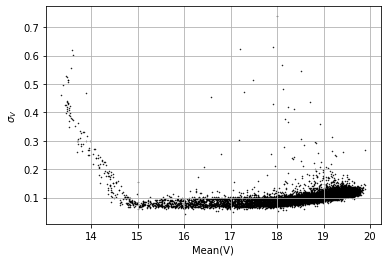

In [47]:
plt.scatter(prom1, desv1, c='k', s=0.25)
plt.xlabel('Mean(V)')
plt.ylabel(r'$\sigma_{V}$')
plt.grid()
plt.savefig('daoMeanDesv_sinATP.pdf')

In [56]:
def filtrar15mag(mag, merr, ids, prom, desv, time):
    
    magt = []
    merrt = []
    idst = []
    promt = []
    desvt = []
    timet = []
    
    for i in tqdm(range(len(prom))):
        if (prom[i]>=15):
            magt.append(mag[i])
            merrt.append(merr[i])
            idst.append(ids[i])
            promt.append(prom[i])
            desvt.append(desv[i])
            timet.append(time[i])
            
        
    return magt, merrt, idst, promt, desvt, timet

In [57]:
mag2, merr2, ids2, prom2, desv2, time2 = filtrar15mag(mag1, merr1, ids1, prom1, desv1, time1)

100%|██████████| 8618/8618 [00:00<00:00, 430069.86it/s]


In [156]:
len(mag2)

8422

In [58]:
with open("mag_2.pickle", "wb") as f:
    pickle.dump(mag2, f)
with open("merr_2.pickle", "wb") as f:
    pickle.dump(merr2, f)
with open("ids_2.pickle", "wb") as f:
    pickle.dump(ids2, f)
with open("time_2.pickle", "wb") as f:
    pickle.dump(time2, f)
with open("prom_2.pickle", "wb") as f:
    pickle.dump(prom2, f)
with open("desv_2.pickle", "wb") as f:
    pickle.dump(desv2, f)

In [37]:
with open("mag_2.pickle", "rb") as f:
    mag2 = pickle.load(f)
with open("merr_2.pickle", "rb") as f:
    merr2 = pickle.load(f)
with open("ids_2.pickle", "rb") as f:
    ids2 = pickle.load(f)
with open("time_2.pickle", "rb") as f:
    time2 = pickle.load(f)
with open("prom_2.pickle", "rb") as f:
    prom2 = pickle.load(f)
with open("desv_2.pickle", "rb") as f:
    desv2 = pickle.load(f)

In [108]:
def func(x, b, c, d):
    return  b*x**2 + c*x + d
popt, pcov = curve_fit(func, prom2, desv2)
b, c, d = popt

In [131]:
fit = 1.22*func(np.array(prom2), b, c, d)
popt

array([ 0.00371551, -0.1205641 ,  1.05761417])

Text(0, 0.5, '$\\sigma_{promV}$')

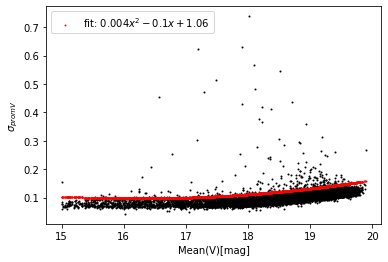

In [137]:
plt.scatter(prom2, desv2, s=1, c='k')
plt.scatter(prom2, fit, s=0.8, c='r', label=r'fit: $0.004x^2 - 0.1x + 1.06$')
plt.legend()
plt.xlabel(r'Mean(V)[mag]')
plt.ylabel(r'$\sigma_{promV}$')

In [133]:
def filtrarfit(fit, mag, merr, ids, prom, desv, time):
    magt = []
    merrt = []
    idst = []
    promt = []
    desvt = []
    timet = []
    for i in tqdm(range(len(prom))):
        if (desv[i] > fit[i]):
            magt.append(mag[i])
            merrt.append(merr[i])
            idst.append(ids[i])
            promt.append(prom[i])
            desvt.append(desv[i])
            timet.append(time[i])
            
        
    return magt, merrt, idst, promt, desvt, timet    

In [134]:
mag3, merr3, ids3, prom3, desv3, time3 = filtrarfit(fit, mag2, merr2, ids2, prom2, desv2, time2) 

100%|██████████| 8422/8422 [00:00<00:00, 842401.65it/s]


In [135]:
len(prom3)

343

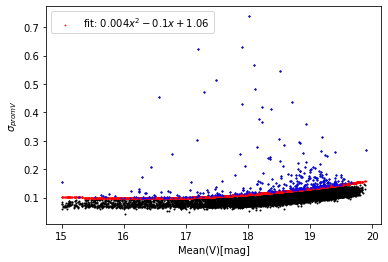

In [138]:
plt.scatter(prom2, desv2, s=1, c='k')
plt.scatter(prom2, fit, s=0.6, c='r', label= r'fit: $0.004x^2 - 0.1x + 1.06$')
plt.scatter(prom3, desv3, s=1, c='b')
plt.legend()
plt.xlabel(r'Mean(V)[mag]')
plt.ylabel(r'$\sigma_{promV}$')
plt.savefig('daoMeanDesv_ajuste.pdf')

In [139]:
len(prom3)

343

In [140]:
with open("mag_3.pickle", "wb") as f:
    pickle.dump(mag3, f)
with open("merr_3.pickle", "wb") as f:
    pickle.dump(merr3, f)
with open("ids_3.pickle", "wb") as f:
    pickle.dump(ids3, f)
with open("time_3.pickle", "wb") as f:
    pickle.dump(time3, f)
with open("prom_3.pickle", "wb") as f:
    pickle.dump(prom3, f)
with open("desv_3.pickle", "wb") as f:
    pickle.dump(desv3, f)

In [141]:
with open("mag_3.pickle", "rb") as f:
    mag3 = pickle.load(f)
with open("merr_3.pickle", "rb") as f:
    merr3 = pickle.load(f)
with open("ids_3.pickle", "rb") as f:
    ids3 = pickle.load(f)
with open("time_3.pickle", "rb") as f:
    time3 = pickle.load(f)
with open("prom_3.pickle", "rb") as f:
    prom3 = pickle.load(f)
with open("desv_3.pickle", "rb") as f:
    desv3 = pickle.load(f)

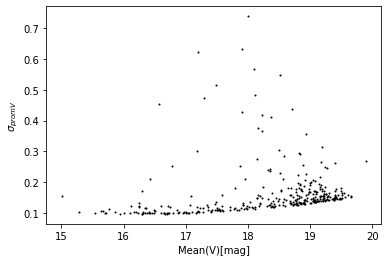

In [144]:
plt.scatter(prom3, desv3, s=1, c='k')
plt.xlabel(r'Mean(V)[mag]')
plt.ylabel(r'$\sigma_{promV}$')
plt.grid
plt.savefig('daoMeanDesv_candidatas.pdf')

In [145]:
def datasinnan(mag, merr, time):
    magt = []
    merrt = []
    timet = []
    for i in range(len(mag)):
        if (np.isnan(mag[i]) == False) and (np.isnan(time[i]) == False):
            timet.append(time[i])
            magt.append(mag[i])
            merrt.append(merr[i])
           
    return magt, merrt, timet

In [146]:
time4 = []
mag4 = []
merr4 = []
ids4 = ids3
prom4 = prom3
desv4= desv3

for i in tqdm(range(len(mag3))):
    magt, merrt, timet = datasinnan(mag3[i], merr3[i], time3[i])
    time4.append(np.array(timet))
    mag4.append(np.array(magt))
    merr4.append(np.array(merrt))

100%|██████████| 343/343 [00:01<00:00, 232.38it/s]


In [147]:
with open("mag_4.pickle", "wb") as f:
    pickle.dump(mag4, f)
with open("merr_4.pickle", "wb") as f:
    pickle.dump(merr4, f)
with open("ids_4.pickle", "wb") as f:
    pickle.dump(ids4, f)
with open("time_4.pickle", "wb") as f:
    pickle.dump(time4, f)
with open("prom_4.pickle", "wb") as f:
    pickle.dump(prom4, f)
with open("desv_4.pickle", "wb") as f:
    pickle.dump(desv4, f)

In [148]:
with open("mag_4.pickle", "rb") as f:
    mag4 = pickle.load(f)
with open("merr_4.pickle", "rb") as f:
    merr4 = pickle.load(f)
with open("ids_4.pickle", "rb") as f:
    ids4 = pickle.load(f)
with open("time_4.pickle", "rb") as f:
    time4 = pickle.load(f)
with open("prom_4.pickle", "rb") as f:
    prom4 = pickle.load(f)
with open("desv_4.pickle", "rb") as f:
    desv4 = pickle.load(f)

In [149]:
with PdfPages('magTdaoSet4.pdf') as pdf: 
    for i in tqdm(range(len(mag4))): 
        plt.scatter(time4[i], mag4[i], c='k', s=0.8) 
        plt.gca().invert_yaxis()
        plt.xlabel('HJD')
        plt.ylabel('V')
        plt.title( f'ID_{ids4[i]}, i={i}') 
        pdf.savefig()
        plt.close()

100%|██████████| 343/343 [00:49<00:00,  6.96it/s]


In [150]:
#funciones para Lombscargle
def darfase(T, t0, P):
    f = np.zeros(len(T))
    i = 0
    for t in T:
        if np.isnan(t)==True:
            t = 0
        a = (t - t0)/P
        b = int((t - t0)/P)
        f[i] = a-b
        i+=1
    return f

def darfrec(t):
    fmax = 1/(1.1/24)
    fmin = 1/9.9
    
    return fmin, fmax

def darDatos(t, t0, m, merr):
    
    fmin, fmax = darfrec(t)
    
    ls = LombScargle(t, m, merr)
    f, pw = ls.autopower(minimum_frequency=fmin, maximum_frequency=fmax)
    
    s95 = ls.false_alarm_level(0.05)
    s99 = ls.false_alarm_level(0.01)
    pwarr = np.sort(pw)
    pint = pwarr[-5:]
    ub = np.where(np.isin(pw, pint))[0]
    fmax = f[ub]
    p = 1/fmax
    Fase=[]
    for i in range(len(p)):
        Fase.append(darfase(t, 0, p[i]))
    
    return pw, f, Fase, p, s95, s99

In [151]:
pw = []
fases = []
fre = []
p = []
s95 = []
s99 = []

for i in tqdm(range(len(mag4))):
    pw1, fre1, fase1,  p1, s951, s991 = darDatos(time4[i], 0, mag4[i], merr4[i])
    pw.append(pw1)
    fases.append(fase1)
    fre.append(fre1)
    p.append(p1)
    s95.append(s951)
    s99.append(s991)   

100%|██████████| 343/343 [00:15<00:00, 22.61it/s]


In [152]:
with open("pw.pickle", "wb") as f:
    pickle.dump(pw, f)
with open("fases.pickle", "wb") as f:
    pickle.dump(fases, f)
with open("fre.pickle", "wb") as f:
    pickle.dump(fre, f)
with open("period.pickle", "wb") as f:
    pickle.dump(p, f)
with open("sig95.pickle", "wb") as f:
    pickle.dump(s95, f)
with open("sig99.pickle", "wb") as f:
    pickle.dump(s99, f)

In [153]:
with open("pw.pickle", "rb") as f:
    pw = pickle.load(f)
with open("fases.pickle", "rb") as f:
    fases = pickle.load(f)
with open("fre.pickle", "rb") as f:
    fre = pickle.load(f)
with open("period.pickle", "rb") as f:
    p = pickle.load(f)
with open("sig95.pickle", "rb") as f:
    s95 = pickle.load(f)
with open("sig99.pickle", "rb") as f:
    s99 = pickle.load(f)

In [154]:
with PdfPages('CurvasDao.pdf') as pdf:
    for i in tqdm(range(len(mag4))):
        fig, axs = plt.subplots(2, 3, figsize=(10,6))
        
        axs[0, 0].plot(fre[i], pw[i], c='k', linewidth=0.5)
        axs[0, 0].set_title( f'ID_{ids4[i]}, i={i}')
        axs[0, 0].set_xlabel('Frequency')
        axs[0, 0].set_ylabel('Power')
        axs[0, 0].axhline(s95[i], color='r', linestyle='--', label='FAL = 0.05')
        axs[0, 0].axhline(s99[i], color='b', linestyle='--',  label='FAL = 0.01')
        axs[0, 0].legend()
        
        for j, periodo in enumerate(p[i]):
            if j<2:
                for k in [-1, 0, 1]:
                    axs[0, j+1].scatter(fases[i][j]+k, mag4[i], s=1, c="darkred")
                axs[0, j+1].invert_yaxis()
                axs[0, j+1].set_xlabel('Fase')
                axs[0, j+1].set_ylabel('V')
                axs[0, j+1].set_title(f'Periodo={round(p[i][j], 3)}[d]')
            else:
                for k in [-1, 0, 1]:
                    axs[1, j-2].scatter(fases[i][j]+k, mag4[i], s=1, c="darkred")
                axs[1, j-2].invert_yaxis()
                axs[1, j-2].set_xlabel('Fase')
                axs[1, j-2].set_ylabel('V')
                axs[1, j-2].set_title(f'Periodo={round(p[i][j], 3)}[d]')
        
        plt.tight_layout()
        pdf.savefig()
        plt.close()
            

100%|██████████| 343/343 [12:00<00:00,  2.10s/it] 


In [170]:
ids4.index(6108.0)

129

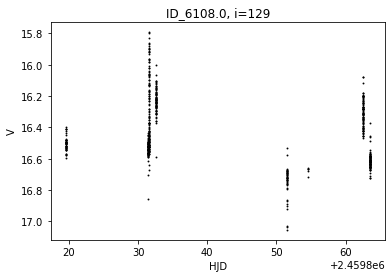

In [171]:
plt.scatter(time4[129], mag4[129], c='k', s=0.8) 
plt.gca().invert_yaxis()
plt.xlabel('HJD')
plt.ylabel('V')
plt.title( f'ID_{ids4[129]}, i={129}') 
plt.savefig('magt6108.pdf')

In [172]:
fmax = 1/(1.1/24)
fmin = 1/9.9
    
ls = LombScargle(time4[129], mag4[129], merr4[129])
fp, pwp = ls.autopower(minimum_frequency=fmin, maximum_frequency=fmax)
    
s95p = ls.false_alarm_level(0.05)
s99p = ls.false_alarm_level(0.01)
pwarr = np.sort(pwp)
pint = pwarr[-5:]
ub = np.where(np.isin(pwp, pint))[0]
fmax = fp[ub]
pp = 1/fmax
Fase=[]
for i in range(len(pp)):
    Fase.append(darfase(time4[129], 0, pp[i]))
    

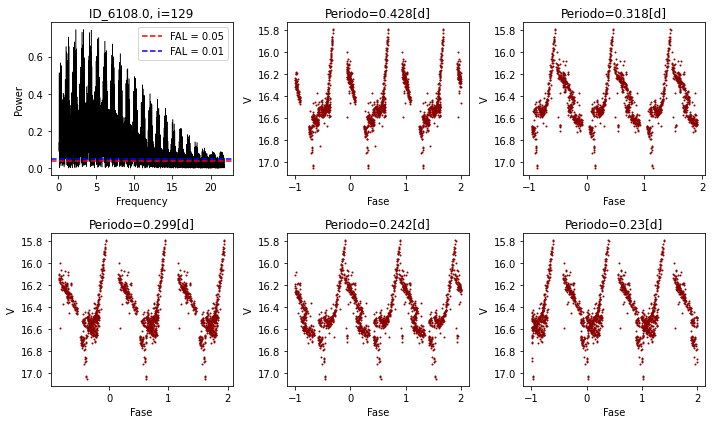

In [173]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
        
axs[0, 0].plot(fp, pwp, c='k', linewidth=0.5)
axs[0, 0].set_title( f'ID_{ids4[129]}, i={129}')
axs[0, 0].set_xlabel('Frequency')
axs[0, 0].set_ylabel('Power')
axs[0, 0].axhline(s95p, color='r', linestyle='--', label='FAL = 0.05')
axs[0, 0].axhline(s99p, color='b', linestyle='--',  label='FAL = 0.01')
axs[0, 0].legend()
        
for j, periodo in enumerate(pp):
    if j<2:
        for k in [-1, 0, 1]:
            axs[0, j+1].scatter(Fase[j]+k, mag4[129], s=1, c="darkred")
        axs[0, j+1].invert_yaxis()
        axs[0, j+1].set_xlabel('Fase')
        axs[0, j+1].set_ylabel('V')
        axs[0, j+1].set_title(f'Periodo={round(pp[j], 3)}[d]')
    else:
        for k in [-1, 0, 1]:
            axs[1, j-2].scatter(Fase[j]+k, mag4[129], s=1, c="darkred")
        axs[1, j-2].invert_yaxis()
        axs[1, j-2].set_xlabel('Fase')
        axs[1, j-2].set_ylabel('V')
        axs[1, j-2].set_title(f'Periodo={round(pp[j], 3)}[d]')
        
plt.tight_layout()
plt.savefig('Periodomagt6108.pdf')